## Step 3 - Climate Analysis and Exploration

In [1]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Import SQL toolkit and ORM
import sqlalchemy
from sqlalchemy import create_engine, inspect, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

In [2]:
engine = create_engine('sqlite:///hawaii.sqlite', echo=False)

In [3]:
#Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [4]:
#Save reference for each class
Measurement=Base.classes.measurement
Station= Base.classes.station
session = Session(engine)

#Running query test 
# test=session.query(Measurement).all()
# for item in test:
#     print(item.prcp)

### Precipitation Analysis

In [5]:
#Exploring the data
inspector= inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station VARCHAR
name VARCHAR
latitute FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
#Retrieve precipitation data for last 12 months
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

date_prcp = [Measurement.date, func.avg(Measurement.prcp)]
date_prcp_table = session.query(*date_prcp).filter(Measurement.date>'2016-08-23').group_by(Measurement.date).all()
#date_prcp_table

In [7]:
#Load precipitation data into a Pandas dataframe
precipitation_df = pd.DataFrame(date_prcp_table, columns=['date', 'prcp'])
precipitation_df.count()
precipitation_df.dtypes

#Converted date format from string to datetime
#precipitation_df['date']=pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
#precipitation_df.dtypes
precipitation_df.set_index('date', inplace=True)
#precipitation_df

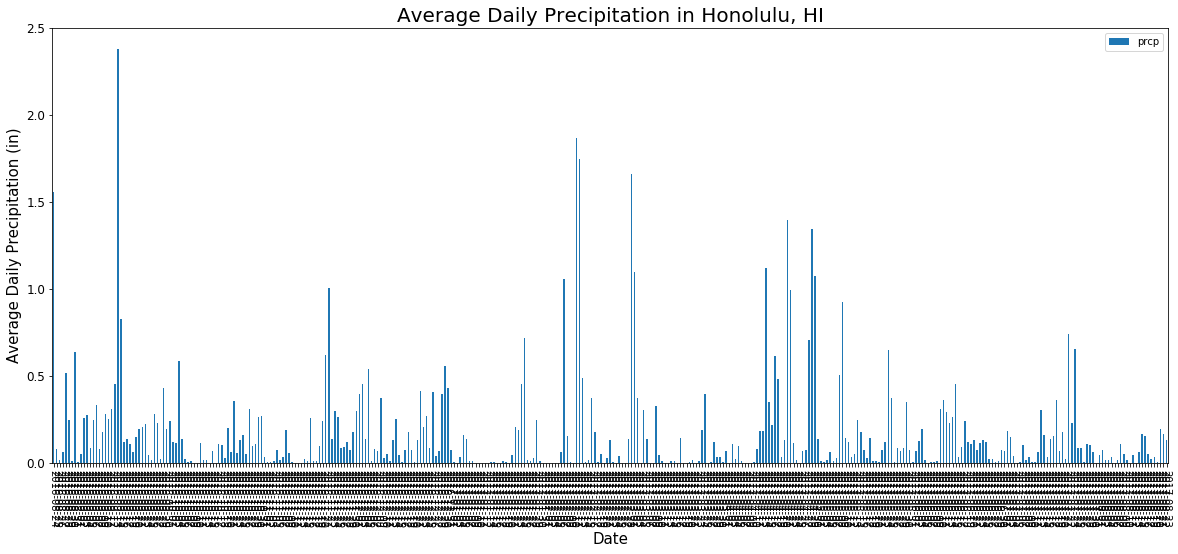

In [8]:
#Plot data
precipitation_df.plot.bar(figsize=(20,8), linewidth=2, rot=270)
#fig, ax = plt.subplots()
plt.xlabel("Date", size=15)
plt.ylabel("Average Daily Precipitation (in)", size=15)
plt.title("Average Daily Precipitation in Honolulu, HI", size=20)
plt.yticks(size='large')
#fig.autofmt_xdate()
plt.show()
#Format x ticks
#months =DateFormatter('%m')
#ax.xaxis.set_major_formatter(months)
#ax.xaxis.set_minor_formatter(months)
# _ plt.xticks(rotation=270)
# ax.xaxis.set_minor_locator(months)

In [9]:
#Summary statistics for precipitation data in Honolulu between 2016-08-24 and 2017-08-23
precipitation_df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


### Station Analysis

In [10]:
#Count total number of stations
session.query(func.count(Station.id)).all()

[(9)]

In [11]:
#List stations and observation counts in descending order
st_obs = [Station.station, Station.name, func.count(Measurement.tobs)]
st_obs_count = session.query(*st_obs).filter(Station.station==Measurement.station).group_by(Station.station).\
    order_by(func.count(Measurement.tobs).desc()).all()
st_obs_count

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2696),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2685),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2572),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2484),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 1937),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1932),
 ('USC00517948', 'PEARL CITY, HI US', 683),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 342)]

In [12]:
#Station with the highest number of observations
st_obs_max = session.query(*st_obs).filter(Station.station==Measurement.station).group_by(Station.station).\
    order_by(func.count(Measurement.tobs).desc()).first()
st_obs_max

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [13]:
#Plot stations with the highest number of observations for 2016-08-24 to 2017-08-23
st_obs = [Measurement.date, Station.station, Measurement.tobs]
st_obs_table_lastyear = session.query(*st_obs).filter(Station.station==Measurement.station).filter(Measurement.date>'2016-08-23').\
    filter(Station.station == 'USC00519281').group_by(Measurement.date).all()

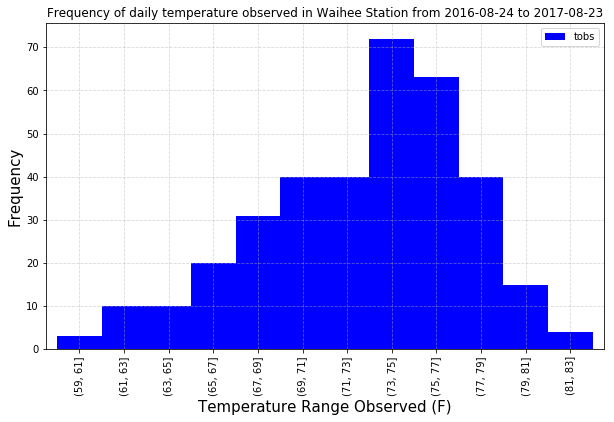

In [18]:
#Load Waihee station temperature observations into a dataframe
temp_obs_df = pd.DataFrame(st_obs_table_lastyear, columns=['date', 'station', 'tobs'])
temp_obs_df = temp_obs_df.drop(['date','station'], axis=1)
temp_obs_df

#Create bins
# temp_obs_df.describe()
# partition = (83-59)/12
bins = list(range(59,84,2))
temp_obs_df = temp_obs_df.groupby(pd.cut(temp_obs_df['tobs'], bins=bins)).tobs.count()
temp_obs_df.plot(kind='bar', legend=True, figsize = (10,6), color='blue', width=1)
plt.xlabel('Temperature Range Observed (F)', size = 15)
plt.ylabel ('Frequency', size = 15)
plt.title('Frequency of daily temperature observed in Waihee Station from 2016-08-24 to 2017-08-23')
plt.grid(True, alpha=0.5, ls='dashed') 
plt.show()

### Temperature Analysis

In [16]:
# #Create calc_temps function and calculate min, max, avg for a chosen date range

def calc_temps(start_date, end_date):  

    qry = session.query(func.min(Measurement.tobs).label("min_temp"), 
                    func.avg(Measurement.tobs).label("avg_temp"),
                    func.max(Measurement.tobs).label("max_temp")
                    ).filter(Measurement.date.between(start_date, end_date))
    
    for stats in qry.all():
        return stats
calc_temps ('2017-08-23', '2017-09-20')

(76, 80.25, 82)

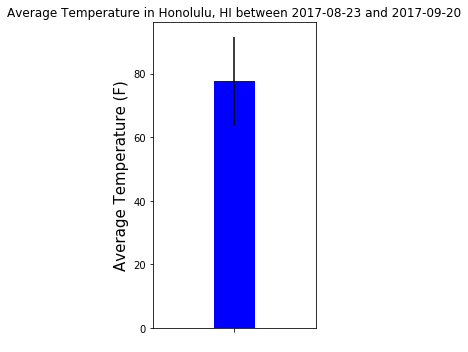

In [17]:
#Calculate the min, avg, and max for the same time of the year the previous year
average_temps= calc_temps('2016-08-23', '2016-09-20')
average_temps_list=list(np.ravel(average_temps))
yerr= average_temps_list[2]-average_temps_list[0]
a= ' '

#Plot min, avg, max, temperature and yerr(tmax-tmin) for date range above. 
fig, ax = plt.subplots(figsize=(5,5))
barplot= ax.bar(a, average_temps_list[1],0.1, align='center', yerr=yerr, color='blue')
plt.xlim(-0.2,0.2)
plt.ylabel("Average Temperature (F)", size=15)
plt.title("Average Temperature in Honolulu, HI between 2017-08-23 and 2017-09-20", size=12)
plt.tight_layout()
plt.show()